In [1]:
import numpy as np
import trimesh
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
import open3d as o3d
import time
import sys,os
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### 1 Mean Curvature and Gaussian Curvature

C:\Users\1\AppData\Local\Temp\ipykernel_11976\187497215.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def color_mesh_by_curvature(mesh, curvatures, cmap= cm.get_cmap('jet')):


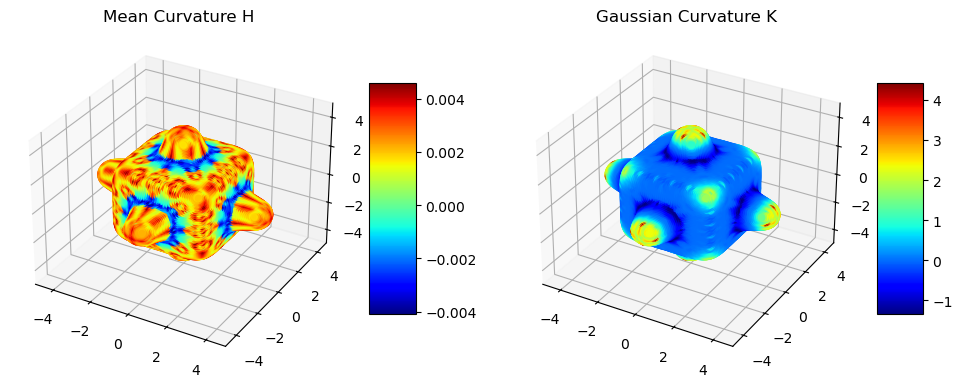

In [8]:
RES_PATH = 'meshes'
# mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/plane.obj')
mesh_src = os.path.join(RES_PATH, 'bumpy-cube.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src

# load mesh, vertices and faces
mesh = trimesh.load(mesh_src)
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)


# get neighbours for every vertex
def get_vertex_neighbors(faces):
    vertex_neighbors = {}
    for face in faces:
        for i in range(3):
            if face[i] not in vertex_neighbors:
                vertex_neighbors[face[i]] = []
            # add the other two vertices of the triangle as neighbors of the current vertex
            vertex_neighbors[face[i]].extend(list(face[:i]) + list(face[i+1:]))

    # delete repeat neighbours
    for vertex in vertex_neighbors: 
        vertex_neighbors[vertex] = list(set(vertex_neighbors[vertex]))
    return vertex_neighbors

# compute mean curvature H for each vertex
def compute_mean_curvature(vertices, vertex_neighbors, normals):
    H = np.zeros(len(vertices))
    for i in range(len(vertices)):
        if i not in vertex_neighbors: continue
        neighbor_vectors = vertices[vertex_neighbors[i]] - vertices[i]
        L = np.sum(neighbor_vectors, axis=0) / len(neighbor_vectors)
        H[i] = -np.linalg.norm(L) / 2
        if(np.dot(L, normals[i]) < 0):
            H[i] = -H[i]

    return H

# use Heron's formula to calculate the area of a triangle given the coordinates of its three vertices
def triangle_area(vertex1, vertex2, vertex3):
    # edge length
    a = np.linalg.norm(vertex1 - vertex2)
    b = np.linalg.norm(vertex2 - vertex3)
    c = np.linalg.norm(vertex3 - vertex1)
    
    # half perimeter
    s = (a + b + c) / 2
    
    # compute area
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return area

# calculate The circumcenter of a triangle.
def calculate_triangle_out_circle_center(A, B, C):
    # Convert input lists to NumPy arrays if they aren't already
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)

    # Calculate the vectors representing the sides of the triangle
    AB = B - A
    AC = C - A
    
    # Calculate the normal vector of the plane defined by the triangle
    AN = np.cross(AB, AC)
    AN = AN / np.linalg.norm(AN)  # Normalize the vector

    # Use the normal vector (AN) and point A to define the plane
    d = np.dot(AN, A)

    # Calculate the coefficients of the linear system
    e, f, g = C - A
    h = np.dot(C - A, (C + A) / 2)
    k, l, m = 2 * (B - A)
    n = np.dot(B, B) - np.dot(A, A)

    # Solve the linear system
    A_matrix = np.array([[AN[0], AN[1], AN[2]], [e, f, g], [k, l, m]])
    B_vector = np.array([d, h, n])
    P = np.linalg.solve(A_matrix, B_vector)
    # print(P, A, B, C)
    return P


# check if a triangle is obtuse by comparing the squares of its sides
def is_obtuse_triangle(A, B, C):
    a2 = np.linalg.norm(C - B)**2
    b2 = np.linalg.norm(C - A)**2
    c2 = np.linalg.norm(B - A)**2
    return a2 + b2 < c2 or a2 + c2 < b2 or b2 + c2 < a2

# calculate Gaussian curvature using mixed cell
def mixed_cells_gaussian_curvature(vertices, faces):
    # Initialize area and angle deficit for each vertex
    voronoi_areas = np.zeros(len(vertices))
    angle_deficits = 2 * np.pi * np.ones(len(vertices))

    # Calculate the Voronoi area and angle deficit for each vertex
    for face in faces:
        A, B, C = vertices[face]
        # Check if the triangle is obtuse
        is_obtuse = is_obtuse_triangle(A, B, C)

        # Compute the circumcenter for non-obtuse triangles
        if not is_obtuse:
            circum_center = calculate_triangle_out_circle_center(A, B, C)

        # Calculate Voronoi area for each vertex in the face
        for i, vertex in enumerate(face):
            opposite_edge = np.delete(face, i)

            if is_obtuse or  circum_center is None:
                # For obtuse triangle, use midpoint of the edge opposite the obtuse angle
                voronoi_areas[vertex] += triangle_area(vertices[vertex], (vertices[opposite_edge[0]] + vertices[opposite_edge[1]]) / 2, 
                                                       (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
                voronoi_areas[vertex] += triangle_area(vertices[vertex], (vertices[opposite_edge[0]] + vertices[opposite_edge[1]]) / 2, 
                                                       (vertices[vertex] + vertices[opposite_edge[1]]) / 2)
            else:
                # For non-obtuse triangle, use circumcenter
                voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
                                                       (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
                voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
                                                       (vertices[vertex] + vertices[opposite_edge[1]]) / 2)

            # Compute the angle at vertex
            vec1, vec2 = vertices[opposite_edge[0]] - vertices[vertex], vertices[opposite_edge[1]] - vertices[vertex]
            angle = np.arccos(np.clip(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)), -1, 1))
            angle_deficits[vertex] -= angle

    # Compute Gaussian curvature
    gaussian_curvature = angle_deficits / voronoi_areas
    gaussian_curvature[np.isnan(gaussian_curvature)] = 0  # Handle NaN values

    return gaussian_curvature

# output as .ply
def color_mesh_by_curvature(mesh, curvatures, cmap= cm.get_cmap('jet')):
    # Normalize the curvature values to [0, 1] for colormap mapping
    curvatures_normalized = (curvatures - np.min(curvatures)) / (np.max(curvatures) - np.min(curvatures))
    # Map the normalized curvature values to a colormap
    colors = cmap(curvatures_normalized)
    # Update the vertex colors of the mesh
    mesh.visual.vertex_colors = (colors[:, :3] * 255).astype(np.uint8)
    return mesh

# visualize curvature
def visualize_curvature(mesh, vertices, H, K):
    fig = plt.figure(figsize=(12, 6))

    # mean curvature H
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Mean Curvature H")
    scatter = ax1.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H, cmap='jet')
    fig.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)
    coloured_mesh = color_mesh_by_curvature(mesh, H)
    coloured_mesh.export("mean_curvature.ply")

    # Gaussian Curvature K
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Gaussian Curvature K")
    scatter = ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=K, cmap='jet')
    fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=5)
    coloured_mesh = color_mesh_by_curvature(mesh, K)
    coloured_mesh.export("gaussian_curvature.ply")

    plt.show()


# get neighbours for each vertex
vertex_neighbors = get_vertex_neighbors(faces)
# compute curvatue
H = compute_mean_curvature(vertices, vertex_neighbors, normals)
K = mixed_cells_gaussian_curvature(vertices, faces)

visualize_curvature(mesh, vertices, H, K)

# print("Mean Curvature H:", H)
# print("Gaussian Curvature K:", K)


##### Check if I get the circumcenter of a triangle right in the above function

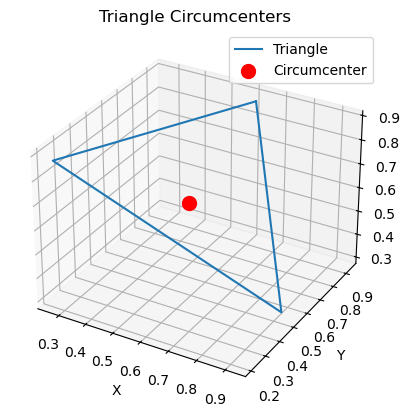

In [9]:
# generate random triangle
num_triangles = 1
triangles = []
is_obtuse = True
for _ in range(num_triangles):
    while is_obtuse:
        A = np.random.rand(3)
        B = np.random.rand(3)
        C = np.random.rand(3)
        is_obtuse = is_obtuse_triangle(A, B, C)
    triangles.append((A, B, C))

# compute circumcenter using the function above
circumcenters = []
for triangle in triangles:
    circum_center = calculate_triangle_out_circle_center(A, B, C)
    circumcenters.append(circum_center)
# visualizatiion
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for triangle, circumcenter in zip(triangles, circumcenters):
    A, B, C = triangle
    ax.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], [A[2], B[2], C[2], A[2]], label='Triangle')
    ax.scatter(circumcenter[0], circumcenter[1], circumcenter[2], color='red', s=100, label='Circumcenter')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Triangle Circumcenters')
ax.legend()

plt.show()


## 2 1st and 2nd Fundamental

In [10]:
import numpy as np

# Function to compute the first and second fundamental forms
def fundamental_forms(a, b, c, u, v):
    # Define the parametric surface function for the ellipsoid
    def ellipsoid(u, v):
        return np.array([a * np.cos(u) * np.sin(v), 
                         b * np.sin(u) * np.sin(v), 
                         c * np.cos(v)])
    
    # Compute the partial derivatives for the tangent vectors
    def partial_u(u, v):
        return np.array([-a * np.sin(u) * np.sin(v), 
                          b * np.cos(u) * np.sin(v), 
                          0])
    
    def partial_v(u, v):
        return np.array([a * np.cos(u) * np.cos(v), 
                         b * np.sin(u) * np.cos(v), 
                        -c * np.sin(v)])
    
    # Compute the normal vector by taking the cross product of the partial derivatives
    def normal_vector(u, v):
        return np.cross(partial_u(u, v), partial_v(u, v))
    
    # Normalize the normal vector
    def unit_normal(u, v):
        n = normal_vector(u, v)
        return n / np.linalg.norm(n)
    
    # Compute the second derivatives
    def second_partial_uu(u, v):
        return np.array([-a * np.cos(u) * np.sin(v), 
                         -b * np.sin(u) * np.sin(v), 
                          0])
    
    def second_partial_uv(u, v):
        return np.array([-a * np.sin(u) * np.cos(v), 
                          b * np.cos(u) * np.cos(v), 
                         0])
    
    def second_partial_vv(u, v):
        return np.array([-a * np.cos(u) * np.sin(v), 
                         -b * np.sin(u) * np.sin(v), 
                         -c * np.cos(v)])
    
    # Compute the coefficients of the first fundamental form
    E = np.dot(partial_u(u, v), partial_u(u, v))
    F = np.dot(partial_u(u, v), partial_v(u, v))
    G = np.dot(partial_v(u, v), partial_v(u, v))
    
    # Compute the coefficients of the second fundamental form
    L = np.dot(second_partial_uu(u, v), unit_normal(u, v))
    M = np.dot(second_partial_uv(u, v), unit_normal(u, v))
    N = np.dot(second_partial_vv(u, v), unit_normal(u, v))
    
    return (E, F, G), (L, M, N)

# Function to compute the normal curvature
def normal_curvature(a, b, c, direction_vector):
    # At the point (a,0,0) =>  u = 0 and v = pi/2
    u = 0
    v = np.pi / 2
    
    # Compute the first and second fundamental forms at (a,0,0)
    (E, F, G), (L, M, N) = fundamental_forms(a, b, c, u, v)
    
    # Compute the normal curvature using the formula k_n = (Ldu^2 + 2Mdu*dv + Ndv^2) / (Edu^2 + 2Fdu*dv + Gdv^2)
    # For direction vector (du, dv), normalize it first
    du, dv = direction_vector
    magnitude = np.sqrt(du**2 + dv**2)
    du, dv = du / magnitude, dv / magnitude
    
    numerator = L*du**2 + 2*M*du*dv + N*dv**2
    denominator = E*du**2 + 2*F*du*dv + G*dv**2
    k_n = numerator / denominator
    
    return k_n

# a example ellipsoid paramterized:
a, b, c = 1, 2, 3
# a example direction(could be any vector on the tangent plane)
direction_vector = (1, 0)

# Compute the normal curvature at (a,0,0) in the given direction
k_n = normal_curvature(a, b, c, direction_vector)
k_n


0.25

## 3 Non-Uniform Curvature

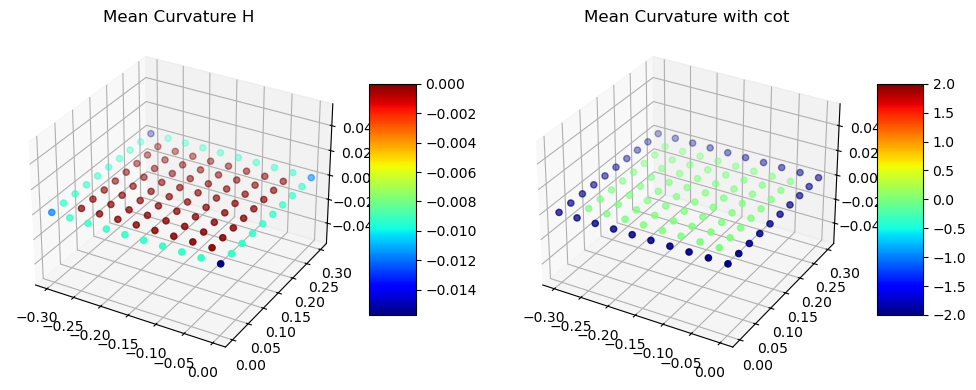

In [13]:
RES_PATH = 'meshes'
# mesh_src = os.path.join(RES_PATH, 'bumpy-cube.obj')
mesh_src = os.path.join(RES_PATH, 'curvatures/plane.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src

# load mesh and get vertices & faces
mesh = trimesh.load(mesh_src)
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)

#compute neighbour j and sum up value of alpha_ij and beita_ij for each vertex
def get_vertex_neighbors_and_cotangent(faces, vertices):
    # initialization
    vertex_neighbors = {i: set() for i in range(len(vertices))}
    cotangent_weights = {i: {} for i in range(len(vertices))}
    voronoi_areas = np.zeros(len(vertices))

    # for each face
    for face in faces:
        A, B, C = vertices[face]
        is_obtuse = is_obtuse_triangle(A, B, C)
        if not is_obtuse:
            circum_center = calculate_triangle_out_circle_center(A, B, C)

        #Calculate Voronoi area for each vertex in the face
        for i, vertex in enumerate(face):
            opposite_edge = np.delete(face, i)

            if is_obtuse or  circum_center is None:
                # For obtuse triangle, use midpoint of the edge opposite the obtuse angle
                voronoi_areas[vertex] += triangle_area(vertices[vertex], np.mean(vertices[opposite_edge], axis=0), 
                                                       (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
                voronoi_areas[vertex] += triangle_area(vertices[vertex], np.mean(vertices[opposite_edge], axis=0), 
                                                       (vertices[vertex] + vertices[opposite_edge[1]]) / 2)
            else:
                # For non-obtuse triangle, use circumcenter
                voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
                                                       (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
                voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
                                                       (vertices[vertex] + vertices[opposite_edge[1]]) / 2)
        
        # for 3 vertices in current face
        for i in range(3):
            # index
            v1, v2, v3 = face[i], face[(i + 1) % 3], face[(i + 2) % 3]
            # pos
            p1, p2, p3 = vertices[v1], vertices[v2], vertices[v3]
            # edge vector
            edge1, edge2 = p1 - p3, p2 - p3
            # edge cot
            cotangent1 = np.dot(edge1, edge2) / np.linalg.norm(np.cross(edge1, edge2))
            edge1, edge2 = p1 - p2, p3 - p2
            cotangent2 = np.dot(edge1, edge2) / np.linalg.norm(np.cross(edge1, edge2))
            
            # update neighbours and cot result for the current vertex
            vertex_neighbors[v1].add(v2)
            vertex_neighbors[v1].add(v3)
            if v2 not in cotangent_weights[v1]:
                cotangent_weights[v1][v2] = 0
            if v3 not in cotangent_weights[v1]:
                cotangent_weights[v1][v3] = 0
            
            # for each corner is calculated twice
            cotangent_weights[v1][v2] += cotangent1 / 2
            cotangent_weights[v1][v3] += cotangent2 / 2
    
    # delete repeated vertex
    for vertex in vertex_neighbors:
        vertex_neighbors[vertex] = list(vertex_neighbors[vertex])
        weights = np.array([cotangent_weights[vertex][neigh] for neigh in vertex_neighbors[vertex]])
        # print(vertex_neighbors[vertex])
        # print(weights)
        cotangent_weights[vertex] = weights
    return vertex_neighbors, cotangent_weights, voronoi_areas


# compute mean curvature with cotangent for wach vertex
def compute_mean_curvature_with_cotangent(vertices, vertex_neighbors, cotangent_weights, normals, voronoi_areas):
    H = np.zeros(len(vertices))
    for i in range(len(vertices)):
        if i not in vertex_neighbors: continue
        neighbor_vectors = vertices[vertex_neighbors[i]] - vertices[i]
        weights = np.array(cotangent_weights[i])
        L = np.sum(neighbor_vectors * weights[:, np.newaxis], axis=0) / (2 * voronoi_areas[i])
        # H[i] = - np.dot(L, normals[i]) / 2
        H[i] = -np.linalg.norm(L) / 2
        if(np.dot(L, normals[i]) < 0):
            H[i] = -H[i]
    return H

# visualize curvature
def visualize_curvature(mesh, vertices, H1, H2):
    fig = plt.figure(figsize=(12, 6))

    # uniform curvature in Q1
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Mean Curvature H")
    scatter = ax1.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H1, cmap='jet')
    fig.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)
    coloured_mesh = color_mesh_by_curvature(mesh, H1)
    coloured_mesh.export("h1.ply")

    # cot curvature in this question
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Mean Curvature with cot")
    scatter = ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H2, cmap='jet', vmin=-2, vmax=2)
    # scatter = ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H2, cmap='jet')
    fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=5)
    H2 = np.clip(H2, -2, 2)
    coloured_mesh = color_mesh_by_curvature(mesh, H2)
    coloured_mesh.export("h2.ply")

    plt.show()

# get vertex neighbors and cotangent
vertex_neighbors, cotangent_weights, voronoi_areas = get_vertex_neighbors_and_cotangent(faces, vertices)
# compute uniform curvature and non uniform curvature
H2 = compute_mean_curvature_with_cotangent(vertices, vertex_neighbors, cotangent_weights, normals, voronoi_areas)
H1 = compute_mean_curvature(vertices, vertex_neighbors, normals)

visualize_curvature(mesh, vertices, H1, H2)


## 4 Laplacian Operator and Reconstruction

#### I used the Barycebtric cells method instead of the mixed cells above to speed up the computation

In [14]:
# calculate the midpoint of an edge
def edge_midpoint(v1, v2):
    return (v1 + v2) / 2

# calculate the centroid of a triangle
def triangle_centroid(v1, v2, v3):
    return (v1 + v2 + v3) / 3

def CentroidArea(vertices, faces):
    vertex_areas = np.zeros(len(vertices))
    
    for face in faces:
        v1, v2, v3 = [vertices[face[i]] for i in range(3)]
        triangle_vertices = np.array([v1, v2, v3])
        triangle_area = trimesh.triangles.area([triangle_vertices])[0]
        for i in range(3):
            vertex_areas[face[i]] += triangle_area / 3

    return vertex_areas

In [22]:
import scipy.sparse as sp
from scipy.sparse import csr_matrix

# Function to compute the cotangent Laplace-Beltrami operator for the mesh
def compute_laplacian(vertices, faces, useM = True):
    n = len(vertices)
    areas = CentroidArea(vertices, faces)
    # Initialize weights and matrix indices
    I = []
    J = []
    W = []
    M_inv_entries = []

    for i in range(n):
        M_inv_entries.append(1.0 / (2.0 * areas[i]))

    # Iterate over faces to compute cotangent weights
    for face in faces:
        for i in range(3):
            j = (i + 1) % 3
            k = (i + 2) % 3
            vi = vertices[face[i]]
            vj = vertices[face[j]]
            vk = vertices[face[k]]
            # compute cotangents for edges (i, j) and (i, k)
            cot_ij = np.dot(vj - vk, vi - vk) / np.linalg.norm(np.cross(vj - vk, vi - vk))
            cot_ik = np.dot(vj - vi, vj - vk) / np.linalg.norm(np.cross(vj - vi, vj - vk))
            # append data for the sparse matrix
            I.append(face[i])
            J.append(face[j])
            W.append(cot_ij / 2.0)
            I.append(face[i])
            J.append(face[k])
            W.append(cot_ik / 2.0)

    # create the sparse matrix
    C = csr_matrix((W, (I, J)), shape=(n, n))
    # set the diagonal
    M_inv = sp.diags(M_inv_entries)

    # If I use add M_inv in the front, the process of question4 will be very slow, so sometimes I set it as false
    # to get result quicker
    L = C
    if(useM):
        L = M_inv @ C
        
    L.setdiag(-np.array(L.sum(axis=1)).flatten())

    return L

In [23]:
from scipy.sparse.linalg import eigsh

RES_PATH = 'meshes'
mesh_src = os.path.join(RES_PATH, 'decomposition/armadillo.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/plane.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src
# load mesh, vertices and faces
mesh = trimesh.load(mesh_src)
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)


# perform the mesh reconstruction using the smallest k eigenvectors
def mesh_reconstruction(vertices, faces, normals, k_values):
    L = compute_laplacian(vertices, faces, False)
    
    # Perform eigen decomposition and reconstruct the mesh for each k
    reconstructions = {}
    for k in k_values:
        eigenvalues, eigenvectors = eigsh(L, k + 1, which='SM')
        eigenvectors = eigenvectors[:, 1:k+1]
        reconstruction = eigenvectors @ eigenvectors.T @ vertices
        reconstructions[k] = reconstruction

    return reconstructions


# reconstructions for k = 5, 15, 50
k_values = [5, 15, 50]
reconstructions = mesh_reconstruction(vertices, faces, normals, k_values)

# Save the reconstructed meshes and provide file paths
output_files = {}
for k, recon_verts in reconstructions.items():
    # Create a new mesh with the reconstructed vertices
    recon_mesh = trimesh.Trimesh(vertices=recon_verts, faces=faces, process=False)
    recon_mesh.export(f'armadillo_reconstructed_k{k}.obj')

output_files


d:\Python\MniConda3\envs\godzilla\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


{}

## Smootihng

## 5 Explicit 

In [28]:
RES_PATH = 'meshes'
# mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
# mesh_src = os.path.join(RES_PATH, 'bumpy-cube.obj')
mesh_src = os.path.join(RES_PATH, 'smoothing/fandisk_ns.obj')
# mesh_src = os.path.join(RES_PATH, 'smoothing/plane_ns.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src

# load
mesh = trimesh.load(mesh_src)
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)

def explicit_smoothing(vertices, faces, lambda_value, iterations=5):
    # compute laplacian operator
    L = compute_laplacian(vertices, faces)
    I = sp.eye(vertices.shape[0])
    # perform the smoothing operation
    for _ in range(iterations):
        vertices = (I + lambda_value * L).dot(vertices)
    return vertices

# set lambda_value (step size) for smoothing
lambda_value = 0.0005

# explicit smoothing
smoothed_vertices = explicit_smoothing(vertices, faces, lambda_value)

# save output file
smoothed_mesh = trimesh.Trimesh(vertices=smoothed_vertices, faces=faces, process=False)
smoothed_mesh.export(f'smoothed_obj_exp.obj')


'# https://github.com/mikedh/trimesh\nv 1.93696527 14.13448921 -0.00699896\nv 0.00337289 15.37173247 -1.35643520\nv 2.17143589 16.66250382 -0.49653774\nv 2.24445089 16.71505129 -0.36487255\nv 2.21977893 16.68330224 -0.15665668\nv 2.31614083 16.76238312 -0.53773712\nv 0.17922263 15.37279843 -1.49638774\nv 4.66785450 13.58977580 -0.20435788\nv 2.33860012 16.78959500 -0.15726823\nv 0.02206548 15.40437098 -1.19652500\nv 2.44537512 16.90928416 -0.50109518\nv 3.50700013 16.73619874 -0.02677872\nv 0.14834425 15.36284424 -1.27431694\nv 2.44241933 16.90806634 -0.22883942\nv 2.55259276 17.01909139 -0.39963480\nv -0.01796091 15.42155870 -0.98206067\nv 2.54652058 17.01184988 -0.20952817\nv 0.00876675 15.39157897 -0.76780704\nv 4.74474240 13.62207549 -0.09717245\nv -0.01534902 15.44058506 -0.62572193\nv 2.70461029 17.12879623 -0.17601878\nv 0.03672537 15.39969380 -0.35964013\nv 2.68061694 17.10225932 -0.30759673\nv 0.01502270 15.42502338 -0.17564319\nv 2.78297335 17.18998228 -0.43168625\nv 0.041615

## 6 Implicit

In [29]:
from scipy.sparse.linalg import spsolve

RES_PATH = 'meshes'
# mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
# mesh_src = os.path.join(RES_PATH, 'bumpy-cube.obj')
mesh_src = os.path.join(RES_PATH, 'smoothing/fandisk_ns.obj')
# mesh_src = os.path.join(RES_PATH, 'smoothing/plane_ns.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src

# load
mesh = trimesh.load(mesh_src)
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)

def implicit_smoothing(vertices, faces, lambda_value, iterations=20):
    # compute laplacian operator
    L = compute_laplacian(vertices, faces)
    I = sp.eye(vertices.shape[0])
    # perform the smoothing operation
    for _ in range(iterations):
        A = I - lambda_value * L
        vertices = spsolve(A, vertices)
    return vertices

# Set lambda_value (step size) for smoothing
lambda_value = 0.005

# explicit smoothing
smoothed_vertices = implicit_smoothing(vertices, faces, lambda_value)

# save output file
smoothed_mesh = trimesh.Trimesh(vertices=smoothed_vertices, faces=faces, process=False)
smoothed_mesh.export(f'smoothed_obj_imp.obj')


'# https://github.com/mikedh/trimesh\nv 1.94269555 14.13563076 -0.00485057\nv 0.11334364 15.26217341 -1.33942216\nv 2.23548203 16.60557691 -0.46137715\nv 2.28383632 16.67832010 -0.36245404\nv 2.27532659 16.63562964 -0.20817547\nv 2.35806136 16.71882179 -0.48389525\nv 0.22890610 15.31656451 -1.48233043\nv 4.59032452 13.74840641 -0.16484343\nv 2.38154550 16.74443240 -0.20966320\nv 0.12404686 15.29020381 -1.18498640\nv 2.49108409 16.84975750 -0.45554085\nv 3.50685584 16.73904348 -0.00255622\nv 0.20867346 15.33599763 -1.27014606\nv 2.48324533 16.86025537 -0.25740540\nv 2.59630156 16.96056128 -0.37829012\nv 0.11020937 15.29837959 -0.97658532\nv 2.59616108 16.95491563 -0.23752805\nv 0.11453466 15.30609007 -0.76462015\nv 4.62841838 13.76387586 -0.13161867\nv 0.11404878 15.31740388 -0.62993315\nv 2.75069332 17.06681976 -0.21870698\nv 0.13219308 15.31167126 -0.37261640\nv 2.71207045 17.05525625 -0.31000411\nv 0.14559281 15.30739235 -0.23095146\nv 2.82439989 17.12356289 -0.39669057\nv 0.17562404

## 7 Test Smoothing

Noise Level: 0.0, Mean Difference between Origin and Noisy: 0.0, Mean Difference between Origin and Smoothed: 0.022686504818577487
Noise Level: 0.011111111111111112, Mean Difference between Origin and Noisy: 0.017768574956287853, Mean Difference between Origin and Smoothed: 0.027092250892900963
Noise Level: 0.022222222222222223, Mean Difference between Origin and Noisy: 0.0353621727058621, Mean Difference between Origin and Smoothed: 0.034258601417905384
Noise Level: 0.03333333333333333, Mean Difference between Origin and Noisy: 0.053579398278800414, Mean Difference between Origin and Smoothed: 0.04220059700108031
Noise Level: 0.044444444444444446, Mean Difference between Origin and Noisy: 0.07081583858127852, Mean Difference between Origin and Smoothed: 0.05070955816584448
Noise Level: 0.05555555555555556, Mean Difference between Origin and Noisy: 0.08782241358371376, Mean Difference between Origin and Smoothed: 0.06014434069575162
Noise Level: 0.06666666666666667, Mean Difference bet

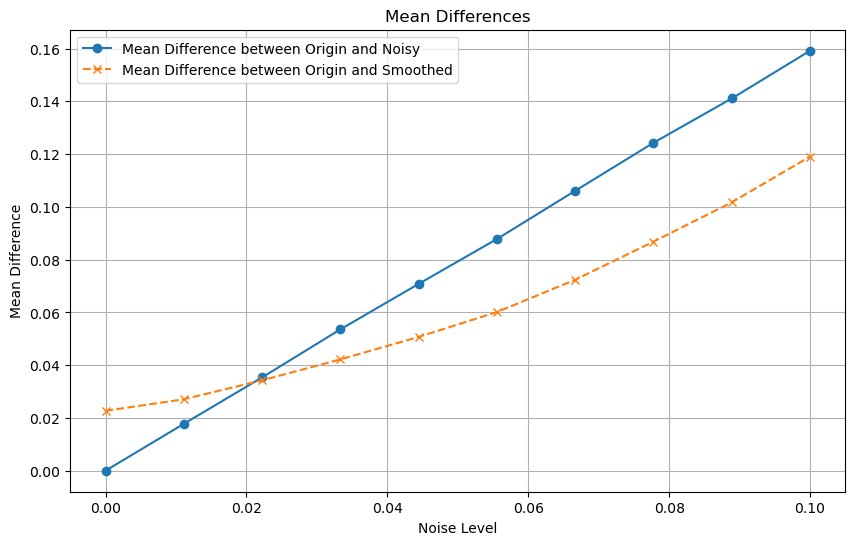

In [31]:
# mesh_src = os.path.join(RES_PATH, 'cube.obj')
mesh_src = os.path.join(RES_PATH, 'smoothing/fandisk_ns.obj')
# load
mesh = trimesh.load(mesh_src)
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)


# initialize
noise_levels_list = []
mean_differences1 = []
mean_differences2 = []

def add_noise_to_vertices(vertices, noise_level):
    noise = np.random.normal(0, noise_level, vertices.shape)
    vertices_noisy = vertices + noise
    return vertices_noisy

noise_levels = np.linspace(0, 0.1, 10)
for i, noise_level in enumerate(noise_levels):
    vertices_noisy = add_noise_to_vertices(vertices, noise_level)
    
    # stepSize
    lambda_value = 0.0007
    smoothed_vertices = implicit_smoothing(vertices_noisy, faces, lambda_value)
    
    original_mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals, process=False)
    noisy_mesh = trimesh.Trimesh(vertices=vertices_noisy, faces=faces, vertex_normals=normals, process=False)
    smoothed_mesh = trimesh.Trimesh(vertices=smoothed_vertices, faces=faces, vertex_normals=normals, process=False)

    difference1 = np.linalg.norm(vertices - vertices_noisy, axis=1).mean()
    difference2 = np.linalg.norm(vertices - smoothed_vertices, axis=1).mean()
    print(f"Noise Level: {noise_level}, Mean Difference between Origin and Noisy: {difference1}, Mean Difference between Origin and Smoothed: {difference2}")

    # to list
    noise_levels_list.append(noise_level)
    mean_differences1.append(difference1)
    mean_differences2.append(difference2)

    # save output mesh
    folder_path = 'Q7'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    original_mesh.export(f'Q7/original_mesh_{i}.obj')
    noisy_mesh.export(f'Q7/noisy_mesh_{i}.obj')
    smoothed_mesh.export(f'Q7/smoothed_mesh_{i}.obj')

# plot
plt.figure(figsize=(10, 6))

# differnce comparison
plt.plot(noise_levels_list, mean_differences1, marker='o', linestyle='-', label='Mean Difference between Origin and Noisy')
plt.plot(noise_levels_list, mean_differences2, marker='x', linestyle='--', label='Mean Difference between Origin and Smoothed')

plt.title('Mean Differences')
plt.xlabel('Noise Level')
plt.ylabel('Mean Difference')
plt.legend()
plt.grid(True)
plt.show()

